Imports

In [1]:
import sys
sys.path.insert(0, "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/")
from pathlib import Path
import torch
from morphing_lander.data_utils.data_utils import get_data_from_rosbag, train_val_split, plot_data, plot_12vector
from morphing_lander.cvae.train import TrainConfigMLP, train
from morphing_lander.cvae.models import MLP
from morphing_lander.mpc.parameters import params_

# get key parameters
model_states_in_idx  = params_.get('model_states_in_idx')
model_inputs_in_idx  = params_.get('model_inputs_in_idx')
model_phi_in         = params_.get('model_phi_in')
model_states_out_idx = params_.get('model_states_out_idx')
model_ninputs        = params_.get('model_ninputs')
model_noutputs       = params_.get('model_noutputs')

print(f"model_ninputs:  {model_ninputs}")
print(f"model_noutputs: {model_noutputs}")

model_ninputs:  12
model_noutputs: 1


Get dataset ready for training

In [2]:
# get data from rosbag
# bag_path = '/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_06_01-15_38_33'
# bag_path    = '/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_05_29-22_58_24' # example
bag_path    = '/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_05_29-08_53_46' # train
type_path   = '/home/m4pc/m4v2-code/m4_ws/src/custom_msgs/msg/MPCStatus.msg'
topic_name  = 'mpc_status'

percent_val = 0.2
data = get_data_from_rosbag(bag_path,
                            type_path,
                            topic_name,
                            smooth_window=None
                            )

# split data into train and validation set
train_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/train_data.pt"
val_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/val_data.pt"

train_data, val_data = train_val_split(data,
                                       percent_val,
                                       model_states_in_idx,
                                       model_inputs_in_idx,
                                       model_phi_in,
                                       model_states_out_idx,
                        )

# save train and validation data for future use
torch.save(train_data, train_data_path)
torch.save(val_data, val_data_path)

print(f"training data points: {train_data.shape[0]}")
print(f"validation data points: {val_data.shape[0]}")


training data points: 17291
validation data points: 4322


Plot dataset

In [ ]:
plot_data(data,
          start_time =None,
          cutoff_time=None,
          name=None,
          inputs=True,
          residuals=True)

Specify training configuration

In [12]:
# Specify the path for the learned models
output_path = Path(
    "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/"
)

train_config = TrainConfigMLP(
    input_dim=model_ninputs,
    output_dim=model_noutputs,
    hidden_layers=[512,512],
    batches_per_epoch=10,
    epochs=250,
    step_size=50,  # steps per decay for lr scheduler
    gamma=0.75,    # multiplicative decay for lr scheduler
    lr=5e-4,
    save_epochs=10,
    val_epochs=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print(f"Device is: {train_config.device}")

Device is: cuda


Create the model

In [13]:
from morphing_lander.cvae.data import ResidualDataset

# create the morphing lander residual dataset
train_dataset = ResidualDataset(train_data_path, model_noutputs)
val_dataset   = ResidualDataset(val_data_path  , model_noutputs)

model = MLP(
    input_dim=train_config.input_dim,
    output_dim=train_config.output_dim,
    hidden_dims=train_config.hidden_layers,
).to(train_config.device)

Train the model

In [14]:
# train the model 
model = train(model,train_dataset,val_dataset,train_config,output_path)

Epoch 0: train_loss=7.036126136779785, val_loss=6.0486094156901045
Epoch 10: train_loss=0.2548259496688843, val_loss=6.2380906740824384
Epoch 20: train_loss=14.065567970275879, val_loss=7.743710994720459
Epoch 30: train_loss=1.6095902919769287, val_loss=6.020909150441487
Epoch 40: train_loss=5.598993301391602, val_loss=6.741777420043945
Epoch 50: train_loss=18.6207218170166, val_loss=6.2715708414713545
Epoch 60: train_loss=2.9436304569244385, val_loss=5.428304990132649
Epoch 70: train_loss=0.32796066999435425, val_loss=5.657284418741862
Epoch 80: train_loss=1.0165064334869385, val_loss=5.7905886967976885
Epoch 90: train_loss=0.10835117101669312, val_loss=5.9622213045756025
Epoch 100: train_loss=3.028714895248413, val_loss=5.162488142649333
Epoch 110: train_loss=4.787102699279785, val_loss=7.323431809743245
Epoch 120: train_loss=0.03438210487365723, val_loss=5.70960267384847
Epoch 130: train_loss=4.727254390716553, val_loss=5.622893651326497
Epoch 140: train_loss=0.2893693447113037, val

Validate

First need to set the residual model to the correct path in morphing_lander.mpc.parameters and compute the compiled residual function based on the trained CVAE

In [3]:
from morphing_lander.mpc.parameters import params_
params_.get('learned_model_path')

PosixPath('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/2024-06-01_17-50-09')

In [4]:
import os
from casadi import external 
from morphing_lander.mpc.parameters import params_

# get residual model
l4c_residual_model = params_.get('l4c_residual_model')

# get c-compiled f_res function
from morphing_lander.mpc.dynamics import f_res
functions_folder = globals()['_dh'][0] / Path('compiled_functions')
os.chdir(functions_folder)
f_res().generate('f_res.c') 
os.system('gcc -fPIC -shared f_res.c -o f_res.so')
f_res_c = external("f_res", functions_folder.absolute().as_posix() +"/f_res.so")

Compute the predicted residual on the dataset

In [5]:
import numpy as np

# get residual predictions 
x_vec   = data['x_vec']
u_vec   = data['u_vec']
phi_vec = data['phi_vec']

cond = np.hstack((x_vec[:,model_states_in_idx],u_vec[:,model_inputs_in_idx]))
if model_phi_in:
    cond = np.hstack((cond,phi_vec[:,np.newaxis]))

# N = x_vec.shape[0]
# Nmid = int(N/2)
# cond1 = np.hstack((x_vec[:Nmid,[2,3,4,5,6,7,8]],u_vec[:Nmid,:],phi_vec[:Nmid,np.newaxis]))
# params1 = l4c_residual_model.get_params(cond1)

# cond2 = np.hstack((x_vec[Nmid:,[2,3,4,5,6,7,8]],u_vec[Nmid:,:],phi_vec[Nmid:,np.newaxis]))
# params2 = l4c_residual_model.get_params(cond2)

# params = np.hstack((params1,params2))
# cond   = np.hstack((cond1,cond2))

f_res_predicted = []
for i in range(cond.shape[0]):
    print(f"{i}/{cond.shape[0]}")
    params_ = l4c_residual_model.get_params(cond[i,:])
    f_res_predicted.append(f_res_c(cond[i,:],params_))
f_res_predicted = np.array(f_res_predicted).squeeze()

0/21614


/home/m4pc/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1/21614
2/21614
3/21614
4/21614
5/21614
6/21614
7/21614
8/21614
9/21614
10/21614
11/21614
12/21614
13/21614
14/21614
15/21614
16/21614
17/21614
18/21614
19/21614
20/21614
21/21614
22/21614
23/21614
24/21614
25/21614
26/21614
27/21614
28/21614
29/21614
30/21614
31/21614
32/21614
33/21614
34/21614
35/21614
36/21614
37/21614
38/21614
39/21614
40/21614
41/21614
42/21614
43/21614
44/21614
45/21614
46/21614
47/21614
48/21614
49/21614
50/21614
51/21614
52/21614
53/21614
54/21614
55/21614
56/21614
57/21614
58/21614
59/21614
60/21614
61/21614
62/21614
63/21614
64/21614
65/21614
66/21614
67/21614
68/21614
69/21614
70/21614
71/21614
72/21614
73/21614
74/21614
75/21614
76/21614
77/21614
78/21614
79/21614
80/21614
81/21614
82/21614
83/21614
84/21614
85/21614
86/21614
87/21614
88/21614
89/21614
90/21614
91/21614
92/21614
93/21614
94/21614
95/21614
96/21614
97/21614
98/21614
99/21614
100/21614
101/21614
102/21614
103/21614
104/21614
105/21614
106/21614
107/21614
108/21614
109/21614
110/21614
111/2161

Plot the predicted residual vs actual residual

<Figure size 1000x800 with 0 Axes>

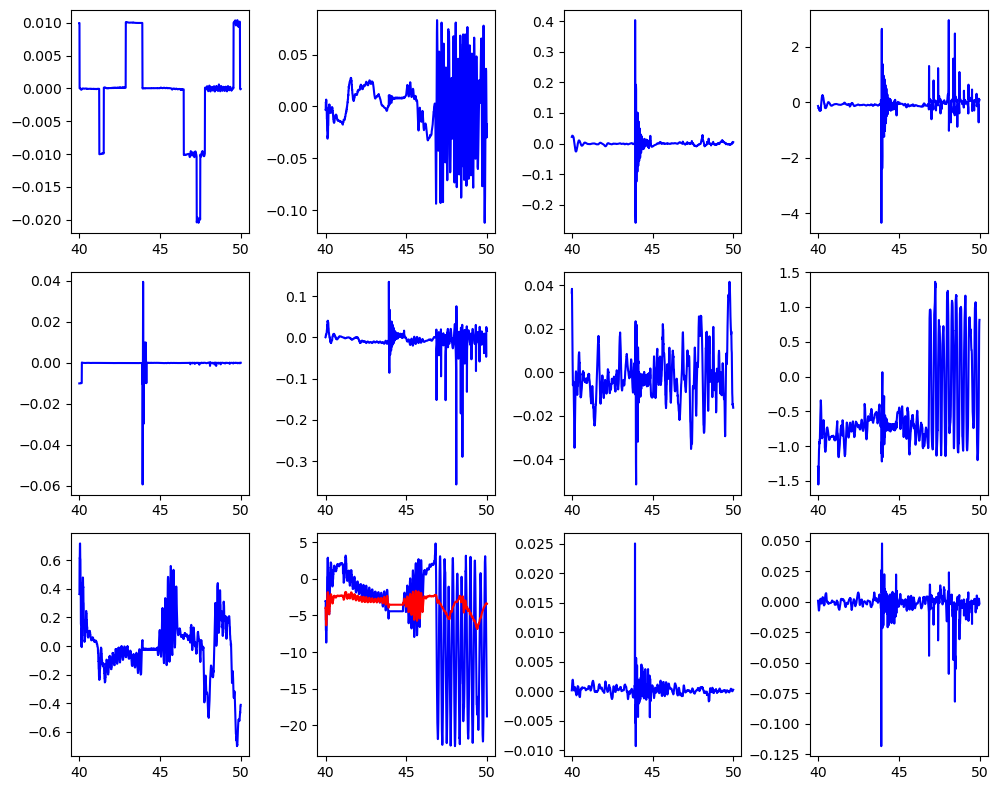

In [10]:
from morphing_lander.data_utils.data_utils import smooth
t_vec     = data['t_vec']
f_res_int = data['f_res_int']
f_res_int_smooth = data['f_res_int_smooth']

f_res_predicted_smooth = smooth(f_res_predicted,1)

fig,axs = plot_12vector(t_vec[:-1],
                        f_res_int_smooth,
                        handles = None,
                        start_time =40,
                        cutoff_time=50,
                        name=None,
                        title=None,
                        labels=None,
                        linestyle='b',
                        display=True,
                        overlay_vec=f_res_predicted_smooth,
                        overlay_idx=model_states_out_idx,
                        overlay_linestyle='r'
                        )


Plot the corrected dynamics predictions

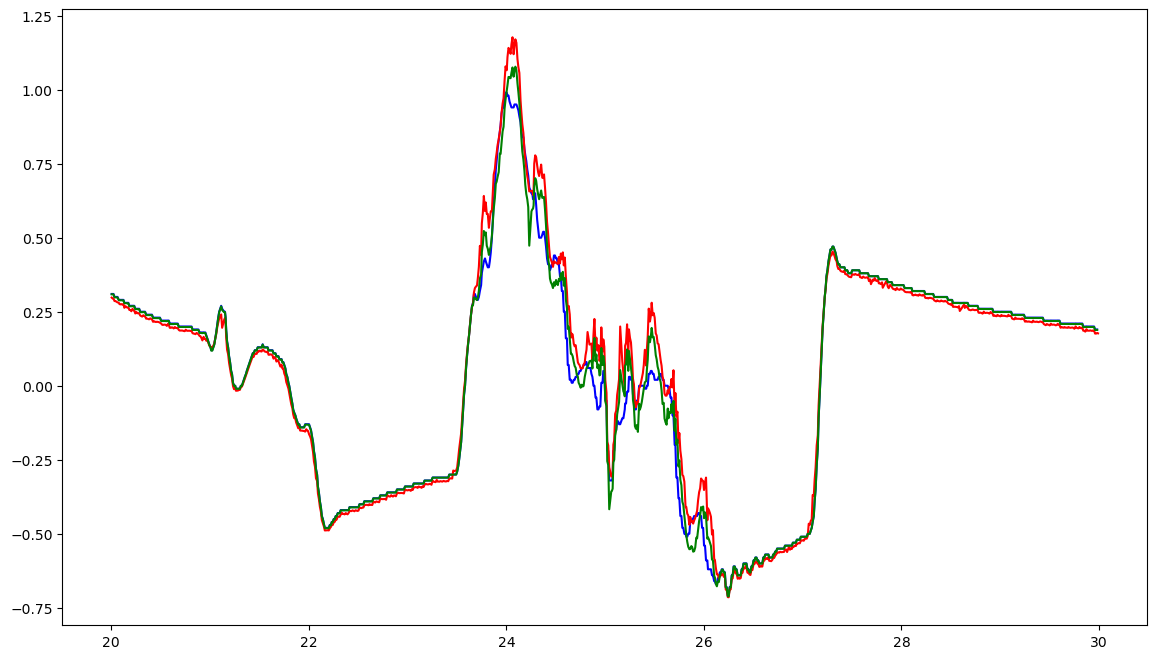

In [8]:
import matplotlib.pyplot as plt 
from morphing_lander.data_utils.data_utils import get_start_end_idx

t_vec      = data['t_vec']
dt_vec     = data['dt_vec']
x_vec      = data['x_vec']
f_vec      = data['f_vec']
f_res_int  = data['f_res_int']
x_next_vec = data['x_next_vec']

x_next_corrected = []
for i in range(x_next_vec.shape[0]):
    f_corrected = np.copy(f_vec[i,:])
    f_corrected[model_states_out_idx] += f_res_predicted[i]
    # f_corrected[model_states_out_idx] += f_res_int[i,model_states_out_idx]
    x_next_corrected.append(x_vec[i,:] + dt_vec[i]*f_corrected)
x_next_corrected = np.array(x_next_corrected)

start_idx,cutoff_idx = get_start_end_idx(t_vec,20,30)

plt.figure(figsize=(14,8))
plt.plot(t_vec[start_idx:cutoff_idx-1],x_vec[start_idx:cutoff_idx-1,8],'b')
plt.plot(t_vec[start_idx:cutoff_idx],x_next_vec[start_idx:cutoff_idx,8],'r')
plt.plot(t_vec[start_idx:cutoff_idx-1],x_next_corrected[start_idx:cutoff_idx-1,8],'g')

# fig,axs = plot_12vector(t_vec[:-1],
#                         x_vec[:-1],
#                         handles = None,
#                         start_time =3,
#                         cutoff_time=10,
#                         name=None,
#                         title=None,
#                         labels=None,
#                         linestyle='b',
#                         display=True,
#                         overlay_vec=x_next_vec,
#                         overlay_idx=[0,1,2,3,4,5,6,7,8,9,10,11],
#                         overlay_linestyle='r'
#                         )